# Worst-case OMP tests

In [1]:
import numpy as np
import scipy as sp
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import sys
sys.path.append("../../")
import pyApproxTools as pat
importlib.reload(pat)

%matplotlib inline

### Worst-case OMP algorithm

We construct a measurement basis $W_m$ based on a given approximation basis $V_n$. Our ambient space $V$ is $H_0^1([0,1])$. Here $V_n$ is the sinusoids, normalised in $H_0^1([0,1])$, so $V_n = \mathrm{span}\{\phi_1,\ldots,\phi_n\}$, where $\phi_k = \frac{\sqrt{2}}{\pi k} \sin(k \pi x)$.

The measurements are assumed to be point evaluations, which have representer in $H_0^1$ of
$$
\omega_{x_0}(x) = \frac{1}{\sqrt{x_0 (1-x_0)}}
\begin{cases}
x (1 - x_0) & \text{for } x \le x_0 \\
(1 - x) x_0 & \text{for } x > x_0
\end{cases}
$$

This implementation of the algorithm finds the vector $v\in V_n$ that is furthest possible from $W_m$, that is at each step we look for 
$$
v_k = argmax_{v\in V_n,\, \|v\|=1} \| v - P_{W_{k-1}} v \|
$$
and then find the dictionary element most closely aligned with this vector
$$
\omega_k 
= \mathrm{argmax}_{\omega\in\mathcal{D}} |\left\langle \omega, v_k - P_{W_{k-1}} v_k \right\rangle| 
$$
It is because of the selection of $v_k$ that we call this the _worst-case_ approach. We find $v_k$ through the SVD decomposition of the cross-gramian of $W_{k-1}$ and $V_n$. Although this is expensive, it works out quite well as the slowest part of the algorithm is actually the dot product search through $\mathcal{D}$, as the SVD code is written in 

### Lets look at $\beta(V_n, W_m)$ for our worst-case OMP basis and a random basis for comparison
Note that this calculation is done for a small dictionary that only has $N=10^3$ elements, to save time, however as we saw in the collective-OMP, the size of the dictionary doesn't have a huge impact in this example.

In [7]:
N = 1e3
dictionary = pat.make_unif_dictionary(N)

ns = [20,40]
np.random.seed(3)
#n = 20
m = 200
bs_comp = np.zeros((len(ns), m))
bs_wcomp = np.zeros((len(ns), m))
bs_rand = np.zeros((len(ns), m))

Vn = pat.make_sin_basis(ns[-1])
Wms_comp = []
Wms_wcomp = []
Wms_rand = []

for j, n in enumerate(ns):

    gbc = pat.CollectiveOMP(dictionary, Vn.subspace(slice(0,n)), verbose=True)
    Wm_comp = gbc.construct_to_m(m)
    Wms_comp.append(Wm_comp)
    Wm_comp_o = Wm_comp.orthonormalise()
    
    wcgbc = pat.WorstCaseOMP(dictionary, Vn.subspace(slice(0,n)), verbose=True)
    Wm_wcomp = wcgbc.construct_to_m(m)
    Wms_wcomp.append(Wm_wcomp)
    Wm_wcomp_o = Wm_wcomp.orthonormalise()

    Wm_rand = pat.make_random_delta_basis(m)
    Wms_rand.append(Wm_rand)
    Wm_rand_o = Wm_rand.orthonormalise()

    BP_comp_l = pat.BasisPair(Wm_comp_o, Vn.subspace(slice(0,n)))
    BP_wcomp_l = pat.BasisPair(Wm_wcomp_o, Vn.subspace(slice(0,n)))    
    BP_rand_l = pat.BasisPair(Wm_rand_o, Vn.subspace(slice(0,n)))
    for i in range(n, m):
        BP_comp = BP_comp_l.subspace(Wm_indices=slice(0,i))
        bs_comp[j, i] = BP_comp.beta()

        BP_wcomp =  BP_wcomp_l.subspace(Wm_indices=slice(0,i))
        bs_wcomp[j, i] = BP_wcomp.beta()
        
        BP_rand = BP_rand_l.subspace(Wm_indices=slice(0,i))
        bs_rand[j, i] = BP_rand.beta()

i 	 || P_Vn (w - P_Wm w) ||
1 : 	 81 	 0.8571343821013426
2 : 	 959 	 0.8478519661242144
3 : 	 814 	 0.5929925737817036
4 : 	 244 	 0.5199125278326096
5 : 	 26 	 0.48416159219343224
6 : 	 901 	 0.3199274022393138
7 : 	 679 	 0.2985225653818852
8 : 	 374 	 0.26312642476426884
9 : 	 151 	 0.26203418166487313
10 : 	 750 	 0.14756995955527202
11 : 	 603 	 0.13852504744923788
12 : 	 448 	 0.12731472282743986
13 : 	 308 	 0.1230894105565528
14 : 	 862 	 0.10431733420279933
15 : 	 194 	 0.08760532948172653
16 : 	 983 	 0.07296362498788501
17 : 	 116 	 0.05720132587427976
18 : 	 930 	 0.049639312212446406
19 : 	 47 	 0.04564995435059706
20 : 	 564 	 0.03924205166611705
21 : 	 716 	 0.03479393843544868
22 : 	 641 	 0.034306212901091766
23 : 	 485 	 0.032058761270104964
24 : 	 412 	 0.030850765953742487
25 : 	 782 	 0.028143467877218494
26 : 	 276 	 0.02589831845260819
27 : 	 340 	 0.023928063825036986
28 : 	 219 	 0.012521433198424296
29 : 	 11 	 0.012498860576901388
30 : 	 838 	 0.012082336378

37 : 	 743 	 0.039207943192002895
38 : 	 570 	 0.029304375433833796
39 : 	 481 	 0.04489901384877004
40 : 	 607 	 0.03892934999641218
41 : 	 892 	 0.03517007577907447
42 : 	 781 	 0.029387772193013154
43 : 	 260 	 0.028276664202938527
44 : 	 53 	 0.03206194992219118
45 : 	 227 	 0.029536436225763588
46 : 	 942 	 0.029448358633116387
47 : 	 990 	 0.027727156116922724
48 : 	 838 	 0.023062566089422587
49 : 	 410 	 0.02033886463501143
50 : 	 811 	 0.024740498574056413
51 : 	 538 	 0.020401659020400142
52 : 	 151 	 0.02124667637300494
53 : 	 663 	 0.020306560431449724
54 : 	 7 	 0.02113415772701617
55 : 	 384 	 0.016762468779754458
56 : 	 513 	 0.01913330335245389
57 : 	 127 	 0.022433347333434023
58 : 	 689 	 0.0203551166365544
59 : 	 359 	 0.01942652261255598
60 : 	 334 	 0.018408121758807808
61 : 	 971 	 0.021027752129620658
62 : 	 713 	 0.020238951429150095
63 : 	 25 	 0.028814907357231773
64 : 	 636 	 0.018114483007750704
65 : 	 198 	 0.01981063667670349
66 : 	 286 	 0.020923614531826

78 : 	 613 	 0.002847119386845196
79 : 	 591 	 0.002743021169852717
80 : 	 546 	 0.0025842060008491145
81 : 	 657 	 0.0025058180830161586
82 : 	 678 	 0.00250195673739897
83 : 	 295 	 0.0022377340071371163
84 : 	 275 	 0.0022324177407834662
85 : 	 315 	 0.0022277297975151085
86 : 	 698 	 0.002111491835283461
87 : 	 737 	 0.0020425796963596528
88 : 	 256 	 0.0019375394745308023
89 : 	 717 	 0.0018495925480295477
90 : 	 990 	 0.0017865619197280798
91 : 	 9 	 0.0017865619197280722
92 : 	 755 	 0.001737175971893741
93 : 	 84 	 0.0014915716228041654
94 : 	 237 	 0.0014407670480255821
95 : 	 221 	 0.0011704794486656824
96 : 	 205 	 0.0011703908659015348
97 : 	 59 	 0.0011063161947964758
98 : 	 940 	 0.0011063161947964025
99 : 	 772 	 0.0010834921168878517
100 : 	 189 	 0.0010736751698236782
101 : 	 917 	 0.0010718155203534021
102 : 	 71 	 0.0010656652611689477
103 : 	 817 	 0.0010024208858576673
104 : 	 803 	 0.0009901577485575967
105 : 	 787 	 0.0009633907531185512
106 : 	 929 	 0.000773770

115 : 	 590 	 0.01098401187338284
116 : 	 654 	 0.010228380231683439
117 : 	 278 	 0.012191681208054514
118 : 	 117 	 0.008995943674978808
119 : 	 898 	 0.01403989073496665
120 : 	 957 	 0.008554328318903986
121 : 	 366 	 0.00962562601338203
122 : 	 794 	 0.00961033580837889
123 : 	 807 	 0.0081896176352549
124 : 	 536 	 0.009030367480826335
125 : 	 242 	 0.010501557130781422
126 : 	 631 	 0.008224139768981516
127 : 	 230 	 0.01306360177698529
128 : 	 139 	 0.008709718491362532
129 : 	 378 	 0.009333428259512375
130 : 	 752 	 0.01100665896849963
131 : 	 449 	 0.008605492013124813
132 : 	 152 	 0.011862321408676726
133 : 	 618 	 0.010504325314648788
134 : 	 856 	 0.009848452225121165
135 : 	 525 	 0.010076012408422888
136 : 	 844 	 0.00922874416954006
137 : 	 52 	 0.010104851874739418
138 : 	 12 	 0.007559673944722824
139 : 	 740 	 0.006850983644348156
140 : 	 289 	 0.008768988996202758
141 : 	 404 	 0.0076791014344134365
142 : 	 729 	 0.008421106802926306
143 : 	 189 	 0.00611620190468

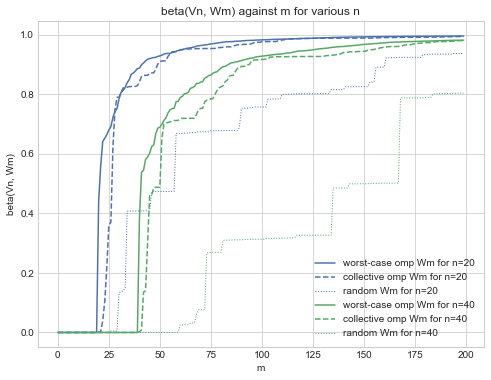

In [8]:
sns.set_palette("deep")
sns.set_style("whitegrid")
cp = sns.color_palette()

axs = []
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, title='beta(Vn, Wm) against m for various n')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')

for i, n in enumerate(ns):
    plt.plot(range(m), bs_wcomp[i, :], label='worst-case omp Wm for n={0}'.format(n), color=cp[i])#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))    
    plt.plot(range(m), bs_comp[i, :], '--', label='collective omp Wm for n={0}'.format(n), color=cp[i])#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))
    plt.plot(range(m), bs_rand[i, :], ':', label='random Wm for n={0}'.format(n), color=cp[i], lw=1)#r'Random $W_m$, $n={{{0}}}$'.format(n))

ax.set(xlabel='m', ylabel='beta(Vn, Wm)')#r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=4)
plt.show()

In [9]:
bs_unif_int = np.zeros((len(ns), m))
Vn = pat.make_sin_basis(ns[-1])

Wms_unif_int = []

for j, n in enumerate(ns):
    for i in range(n, m):
        Wm_unif_int = pat.Basis([pat.FuncVector(params=[[x]],coeffs=[[1.0]],funcs=['H1UIDelta']) for x in np.linspace(0.0, 1.0, i, endpoint=False)+0.5/i])
        Wm_unif_int_o = Wm_unif_int.orthonormalise()

        BP_ui = pat.BasisPair(Wm_unif_int_o, Vn.subspace(slice(0,n)))
        bs_unif_int[j, i] = BP_ui.beta()

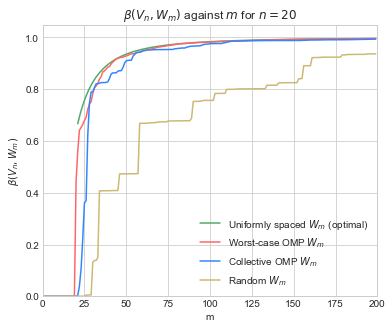

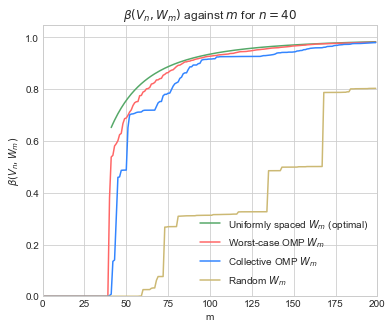

In [10]:
sns.set_palette("deep")
sns.set_style("whitegrid")
cp = sns.color_palette()

bl = (51/255, 133/255, 255/255)
re = (255/255, 102/255, 102/255)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n=20$')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')

#for i, n in enumerate(ns):
i=0
n=ns[i]
plt.plot(range(n+1,m), bs_unif_int[i, n+1:], label=r'Uniformly spaced $W_m$ (optimal)'.format(n), color=cp[1])
plt.plot(range(m), bs_wcomp[i, :], label=r'Worst-case OMP $W_m$'.format(n), color=re)#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))    
plt.plot(range(m), bs_comp[i, :], label=r'Collective OMP $W_m$'.format(n), color=bl)#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))
plt.plot(range(m), bs_rand[i, :], label=r'Random $W_m$'.format(n), color=cp[4])#r'Random $W_m$, $n={{{0}}}$'.format(n))

ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$', xlim=[0,200], ylim=[0,1.05])#r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=4)
plt.savefig('WCOMPvsCOMPvsUnif_20_new.pdf')
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n=40$')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')

i=1
n=ns[i]
plt.plot(range(n+1,m), bs_unif_int[i, n+1:], label=r'Uniformly spaced $W_m$ (optimal)'.format(n), color=cp[1])
plt.plot(range(m), bs_wcomp[i, :], label=r'Worst-case OMP $W_m$'.format(n), color=re)#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))    
plt.plot(range(m), bs_comp[i, :], label=r'Collective OMP $W_m$'.format(n), color=bl)#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))
plt.plot(range(m), bs_rand[i, :], label=r'Random $W_m$'.format(n), color=cp[4])#r'Random $W_m$, $n={{{0}}}$'.format(n))

ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$', xlim=[0,200], ylim=[0,1.05])#r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=4)
plt.savefig('WCOMPvsCOMPvsUnif_40_new.pdf')
plt.show()

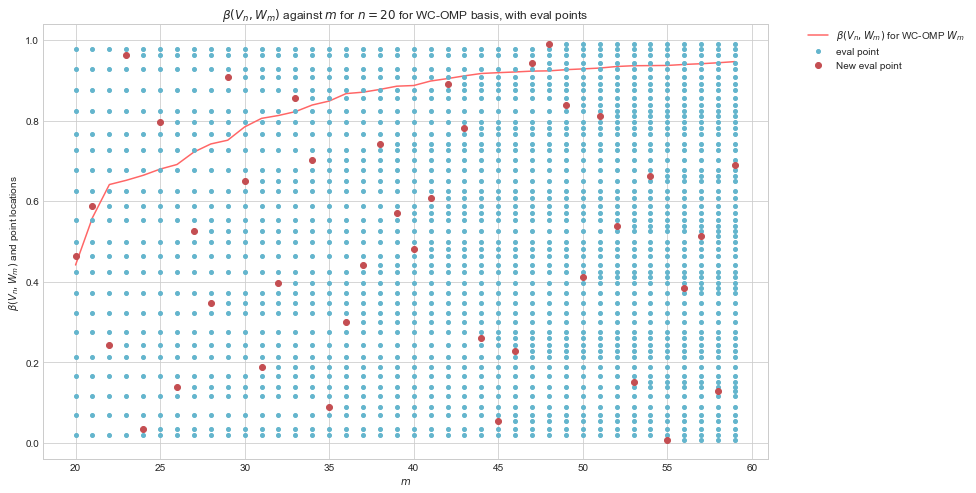

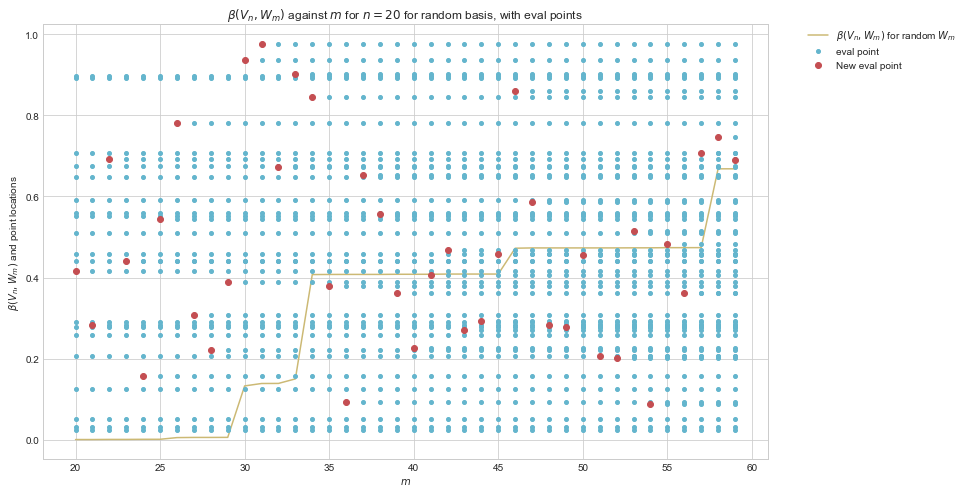

In [11]:
sns.set_palette("deep")
sns.set_style("whitegrid")
cp = sns.color_palette()

bl = (51/255, 133/255, 255/255)
re = (255/255, 102/255, 102/255)


# Plot the evaluation points in the Wm_rand basis 
# (note that the basis is infact orthonormalised so this isn't *quite* an accurate picture)
Wm_points = [vec.params_array(0)[0] for vec in Wms_wcomp[0].vecs]
n = ns[0]

axs = []
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n={{{0}}}$ for WC-OMP basis, with eval points'.format(n))
ax.set(xlabel=r'$m$', ylabel=r'$\beta(V_n, W_m)$ and point locations')
plt.plot(range(n,n+40), bs_wcomp[0,20:60], color=re, label=r'$\beta(V_n, W_m)$ for WC-OMP $W_m$')

plt.plot(n * np.ones(n-1), Wm_points[:n-1], 'o', color=cp[5], markersize=4, label='eval point')
plt.plot(n, Wm_points[n-1], 'o', color=cp[2], markersize=6, label='New eval point')
for m_plot in range(n, n+40-1):
    plt.plot((m_plot+1) * np.ones(m_plot), Wm_points[:m_plot], 'o', color=cp[5], markersize=4)
    plt.plot(m_plot+1, Wm_points[m_plot], 'o', color=cp[2], markersize=6)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('PointEvalLoc_WCOMP_20.pdf')
plt.show()


# Plot the evaluation points in the Wm_rand basis 
# (note that the basis is infact orthonormalised so this isn't *quite* an accurate picture)
Wm_points = [vec.params_array(0)[0] for vec in Wms_rand[0].vecs]

axs = []
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n={{{0}}}$ for random basis, with eval points'.format(n))
ax.set(xlabel=r'$m$', ylabel=r'$\beta(V_n, W_m)$ and point locations')
plt.plot(range(n,n+40), bs_rand[0,20:60], color=cp[4], label=r'$\beta(V_n, W_m)$ for random $W_m$')

plt.plot(n * np.ones(n-1), Wm_points[:n-1], 'o', color=cp[5], markersize=4, label='eval point')
plt.plot(n, Wm_points[n-1], 'o', color=cp[2], markersize=6, label='New eval point')
for m_plot in range(n, n+40-1):
    plt.plot((m_plot+1) * np.ones(m_plot), Wm_points[:m_plot], 'o', color=cp[5], markersize=4)
    plt.plot(m_plot+1, Wm_points[m_plot], 'o', color=cp[2], markersize=6)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('PointEvalLoc_rand_20.pdf')
plt.show()


### Fix a minimum $\beta^*$ and vary $n$, plot resulting $m^*$

This result is actually found using the script ```scripts/01_m_star_tests.py``` and the accompanying ```make_01_scripts.py``` which produces the batch job for cluster computers. Here we just import the results which are found in csv files imported from the computing cluster.

Note that this, at present, is for the value $\beta^* = 0.5$.

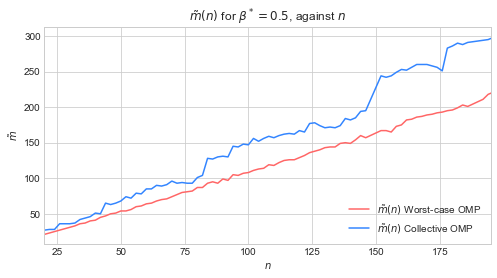

In [18]:
data_dir = '../../scripts/omp/'
comp_file = data_dir + 'comp_sin_m_star.csv'
wcomp_file = data_dir + 'wcomp_sin_m_star.csv'

ms_comp = np.loadtxt(comp_file)
ms_wcomp = np.loadtxt(wcomp_file)

sns.set_palette("deep")
sns.set_style("whitegrid")
cp = sns.color_palette()

bl = (51/255, 133/255, 255/255)
re = (255/255, 102/255, 102/255)

axs = []
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1, title=r'$\tilde{m}(n)$ for $\beta^*=0.5$, against $n$')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')

plt.plot(ms_wcomp[:,0], ms_wcomp[:,1], label=r'$\tilde{m}(n)$ Worst-case OMP', color=re)
plt.plot(ms_comp[:,0], ms_comp[:,1], label=r'$\tilde{m}(n)$ Collective OMP', color=bl)

ax.set(xlabel='$n$', ylabel=r'$\tilde{m}$', xlim=[20,195])#r'$m$', ylabel=r'$\beta(V_n, W_m)$')
ax.xaxis.set_ticks(np.arange(25, 200, 25))
plt.legend(loc=4)
plt.savefig('m_star_COMP_vs_WCOMP_new.pdf')
plt.show()


### Fix a minimum $\beta^*$ and find resulting $m^*$ with an incremental $V_n$

That is, for a given $n$, say we have found $m^*(n)$ and we have corresponding $W_{m^*(n)}$, then what is the $m^*(n+1)$ if we *keep* $W_{m^*(n)}$ and use OMP to find the next few measurements to satisfy $\beta(V_{n+1}, W_{m^*(n_1)}) > \beta$?

This result is actually found using the script ```scripts/03_m_n_incremental.py```. Here we just import the results which are found in csv files imported from the computing cluster.

Again we have the value $\beta^* = 0.5$.

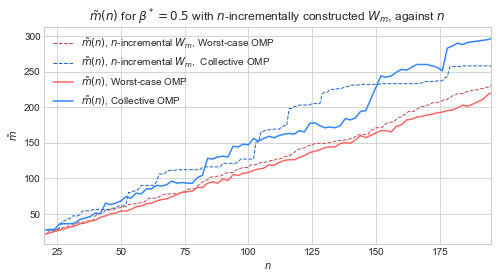

In [17]:
data_dir = '../../scripts/omp/'
comp_file = data_dir + 'comp_sin_n_incr_m_star.csv'
wcomp_file = data_dir + 'wcomp_sin_n_incr_m_star.csv'

ms_nincr_comp = np.loadtxt(comp_file)
ms_nincr_wcomp = np.loadtxt(wcomp_file)

sns.set_palette("deep")
sns.set_style("whitegrid")
cp = sns.color_palette()

bl = (51/255, 133/255, 255/255)
re = (255/255, 102/255, 102/255)

bl_d = (0.75*51/255, 0.75*133/255, 0.75*255/255)
re_d = (0.75*255/255, 0.75*102/255, 0.75*102/255)

axs = []
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1, title=r'$\tilde{m}(n)$ for $\beta^*=0.5$ with $n$-incrementally constructed $W_m$, against $n$')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')

plt.plot(ms_nincr_wcomp[:,0], ms_nincr_wcomp[:,1], '--', label=r'$\tilde{m}(n)$, $n$-incremental $W_m$, Worst-case OMP', color=re_d, lw=1)
plt.plot(ms_nincr_comp[:,0], ms_nincr_comp[:,1], '--', label=r'$\tilde{m}(n)$, $n$-incremental $W_m$,  Collective OMP', color=bl_d, lw=1)

plt.plot(ms_wcomp[:,0], ms_wcomp[:,1], '-', label=r'$\tilde{m}(n)$, Worst-case OMP', color=re)
plt.plot(ms_comp[:,0], ms_comp[:,1], '-', label=r'$\tilde{m}(n)$, Collective OMP', color=bl)

ax.set(xlabel='$n$', ylabel=r'$\tilde{m}$', xlim=[20,195])#r'$m$', ylabel=r'$\beta(V_n, W_m)$')
ax.xaxis.set_ticks(np.arange(25, 200, 25))
plt.legend(loc=0)
plt.savefig('n_incr_COMP_vs_WCOMP_new.pdf')
plt.show()
